<a href="https://colab.research.google.com/github/AnetaKovacheva/Adult-income-explained-with-SHAP/blob/main/Adult_income_explained_with_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpret Machine Learning model outputs with SHAP

One of the most challenging Machine Learning tasks is to interpret or explain model predictions or outputs. I use the [*Census Income* data](https://archive.ics.uci.edu/ml/datasets/Census+Income) (also known as *Adult* dataset) to explore SHAP library.

This dataset is used for predicting as to if a person's income would exceed $50 000 per year, or not, based on census data. Thus, we have a classification task to solve. 

The work follows the regular Machine Learning supervised learning approach: load, explore, and clean data; data modelling, prediction, evaluation model performance, and interpretation. I use `RandomForestClassifier()` and `XGBoostClassifier()` to predict labels, and SHAP - to explain importance of each feature for model output.

The focus of this work is not on EDA or modelling, but on SHAP framework and on explaining Machine Learning models.

### Imports

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report
import xgboost as xgb

I use Google Colaboratory, which requires installing SHAP library.

In [4]:
!pip install shap

In [5]:
import shap

## 1. Load data

*Adult* (*Census income*) data is available at [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). There are train and test datasets, and a data describing file. Both datasets are loaded and stored in `adult_train` and `adult_test`, respectively. DataFrames do not come with column titles. For this reason, `header` is set to `None`. Furthermore, an extra line on the first row in the testing data is skipped because it does not hold any relevant information.

In [6]:
adult_train = pd.read_csv("/content/drive/MyDrive/small_tasks/census_income/adult.data", header = None)
adult_test = pd.read_csv("/content/drive/MyDrive/small_tasks/census_income/adult.test", skiprows = 1, header = None)

## 2. Exploratory Data Analysis

Both DataFrames are explored, visualized, and cleaned if and where necessary in this section.

### 2.1. Display DataFrames
Train and test DataFrames seem identical. It could be seen that both do not have column titles. These are provided in the data description file.

In [7]:
adult_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [8]:
adult_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


### 2.2. Add column titles 

Both datasets have 14 columns (features). Their names are: 

- `age` (holds continuous values - age of individuals)

- `workclass` (shows employment status, which can be: *Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked*)

- `fnlwgt` (holds continuous values; further explanation is not provided; it is not clear what these values mean)

- `education` (categorical variable, possible values: *Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool*)

- `education-num` (continuous values, most likely shows the number of years in education)

- `marital-status` (categorical variable, possible values: *Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse*)

- `occupation` (categorical variable, possible values: *Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces*)

- `relationship` status (categorical variable, possible values: *Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried*)

- `race` (categorical variable, possible values: *White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black*)

- `sex` (categorical variable, possible values: *Female, Male*)

- `capital-gain` (continuous variable, showing positive investment result)

- `capital-loss` (continuous variable, showing negative investment result)

- `hours-per-week` (continuous variable, showing the number of hours an individual works per week)

- `native-country` (categorical variable, possible values: *United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands*)

- `income` (categorical variable, label, possible values: *>50K, <=50K.*)

Column titles were added by applying the function below over both datasets.

In [9]:
def add_columns_title(dataframe):
  """
  Add column names to DataFrame.
  Args:
    Pandas DataFrame
  Returns:
    DataFrame with column names.
  """
  dataframe.columns = ["age", "work_class", "code", "education", "education_num", 
                       "marital_status", "occupation", "relationship", "race", 
                       "sex", "capital_gain", "capital_loss", "hours_per_week", 
                       "native_country", "income"]
  return dataframe

In [10]:
adult_train = add_columns_title(adult_train)
adult_test = add_columns_title(adult_test)

A brief check confirms column titles were successfully added.

In [11]:
adult_train.head()

,age,work_class,code,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [12]:
adult_test.head()

,age,work_class,code,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


### 2.3. Check DataFrame shape, data types, and missing values

There are 32561 samples in train, and 16281 - in test data. Both datasets have 15 columns.

In [13]:
adult_train.shape, adult_test.shape

((32561, 15), (16281, 15))

There are not missing values in both tables. `age`, `code`, `education_num`, `capital_gain`, `capital_loss`, and `hours_per_week` hold *integers*; the other columns have *strings*.

In [14]:
adult_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   work_class      32561 non-null  object
 2   code            32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [15]:
adult_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16281 non-null  int64 
 1   work_class      16281 non-null  object
 2   code            16281 non-null  int64 
 3   education       16281 non-null  object
 4   education_num   16281 non-null  int64 
 5   marital_status  16281 non-null  object
 6   occupation      16281 non-null  object
 7   relationship    16281 non-null  object
 8   race            16281 non-null  object
 9   sex             16281 non-null  object
 10  capital_gain    16281 non-null  int64 
 11  capital_loss    16281 non-null  int64 
 12  hours_per_week  16281 non-null  int64 
 13  native_country  16281 non-null  object
 14  income          16281 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


### 2.4. Remove white space

It turned out that there is a single leading white space in all categorical features, in both datasets. The function below removes it.

In [16]:
adult_train["work_class"].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

In [17]:
def whitespace_remover(dataframe):
  """
  Removes extra leading and tailing white space from column values.
  Args:
    DataFrame
  """
  for i in dataframe.columns:
    if dataframe[i].dtype == "object":
      dataframe[i] = dataframe[i].map(str.strip)
    else:
      pass

In [18]:
whitespace_remover(adult_train)
whitespace_remover(adult_test)

### 2.5. Explore and clean columns

#### Column `Code`

There are 21648 unique `code` values in the training data. These, most likely, would not reveal any meaningful relationship with persons income. For this reason, it is removed from both DataFrames. 

In [19]:
len(adult_train["code"].unique())

21648

In [20]:
adult_train.drop("code", axis = 1, inplace = True)
adult_test.drop("code", axis = 1, inplace = True)

#### Column `age`

Continuous values are displayed on histograms. The function below plots feature distributions both of train and test data. Number of bins could be adjusted.

In [21]:
def plot_distribution(col, bins):
  """
  Plots distribution of values in a column of both train and test data.
  Args:
    col: column name which values' distribution to be displayed
    bins: number of histogram bins
  """
  plt.figure(figsize = (8, 3))
  plt.subplot(121)
  plt.title(f"{col} distribution in train data")
  plt.hist(adult_train[col], bins = bins, color = "tab:blue")

  plt.subplot(122)
  plt.title(f"{col} distribution in test data")
  plt.hist(adult_test[col], bins = bins, color = "tab:orange")

  plt.tight_layout()
  plt.show()

Most individuals in both sets are aged between 20 and 50. Values in train and test data have similar distribution.

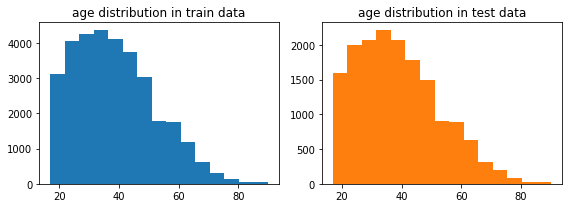

In [22]:
plot_distribution("age", 15)

#### Column `capital gain`

Most people (92%) didn't record any capital gain for the observed period. A tiny share earned up to \$ 20 000, and only a few - around \$ 100 000.

In [23]:
print(f"Persons recorded $0.00 capital gain in train data: {np.round(len(adult_train[adult_train['capital_gain'] == 0]) / len(adult_train) * 100)}%.")
print(f"Persons recorded $0.00 capital gain in test data: {np.round(len(adult_test[adult_test['capital_gain'] == 0]) / len(adult_test) * 100)}%.")

Persons recorded $0.00 capital gain in train data: 92.0%.
Persons recorded $0.00 capital gain in test data: 92.0%.


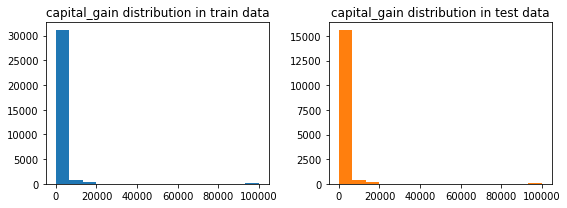

In [24]:
plot_distribution("capital_gain", 15)

#### Column `capital loss`

Similarly, 95% of people didn't lose money from investments. The remaining declared loss of up to \$ 3000 or \$ 4000.

In [25]:
print(f"Persons recorded $0.00 capital gain in train data: {np.round(len(adult_train[adult_train['capital_loss'] == 0]) / len(adult_train) * 100)}%.")
print(f"Persons recorded $0.00 capital gain in test data: {np.round(len(adult_test[adult_test['capital_loss'] == 0]) / len(adult_test) * 100)}%.")

Persons recorded $0.00 capital gain in train data: 95.0%.
Persons recorded $0.00 capital gain in test data: 95.0%.


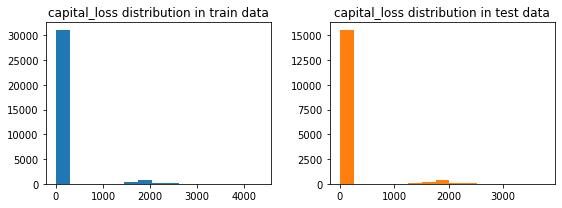

In [26]:
plot_distribution("capital_loss", 15)

#### Column `hours per week`

The plots below show most people worked 40 hours a week (both in train and test data). Still, there are individuals who worked less (e.g., 20 - 30 hours weekly), or more (e.g., 50 - 60 hours). As above, both sets have similar distribution.

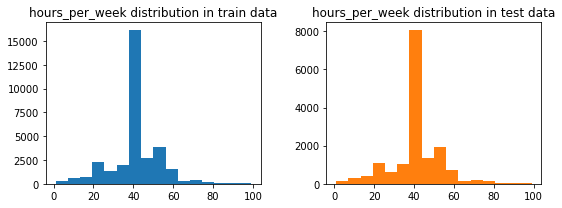

In [27]:
plot_distribution("hours_per_week", 16)

#### Column `work class`

Categorical values are visulized on count plots. They show the number of items per class (category). The function below displays counts in a feature in both train and test data.

In [28]:
def plot_counts(col, order = None):
    """
    Counts and plots categorical features.
    Args: 
      a feature; optional: order of display.
    Return: 
      plot of counts in categorical features.
    """ 
    plt.figure(figsize = (12, 5))
    
    plt.subplot(121)
    plt.title(f"{col} in train data")
    ax = sns.countplot(data = adult_train, x = col, palette = "deep", order = order)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

    plt.subplot(122)
    plt.title(f"{col} in test data")
    ax = sns.countplot(data = adult_test, x = col, palette = "deep", order = order)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

    plt.tight_layout()
    plt.show()

Most people work for private companies (regardless of the dataset they belong to). Relatively equal number are civil servants or self-employed.

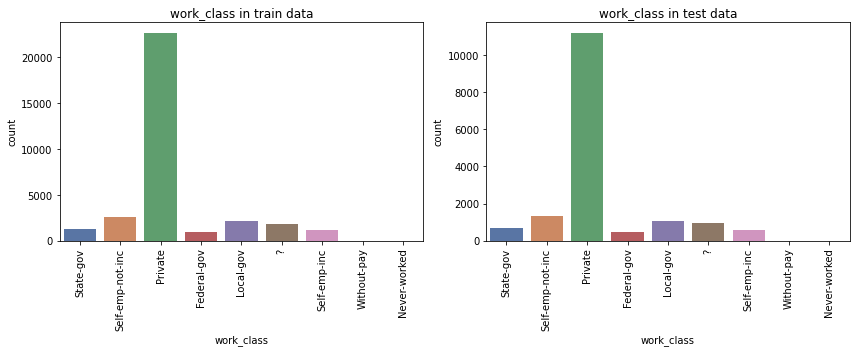

In [29]:
plot_counts("work_class", ['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov', 'Local-gov', '?', 'Self-emp-inc', 
                           'Without-pay', 'Never-worked'])

#### Column `education`

Most people in both sets are high school or college graduates. A significant share have completed Bachelors or Master's degree.

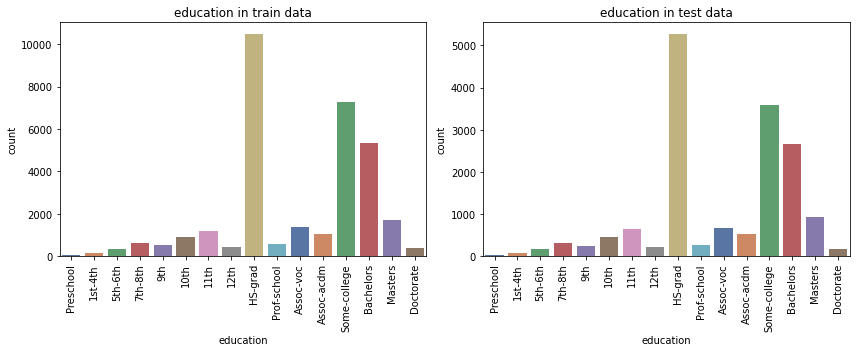

In [30]:
plot_counts("education", ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad',
 'Prof-school', 'Assoc-voc', 'Assoc-acdm', 'Some-college', 'Bachelors', 'Masters', 'Doctorate'])

#### Column `number of years in education`

Completed school grade or university level matches the years spent in education - most people studied 9 or 10 years (which corresponds to high or vocational school) or 13 - 14 years (for those enrolled in college or Bachelor programs).

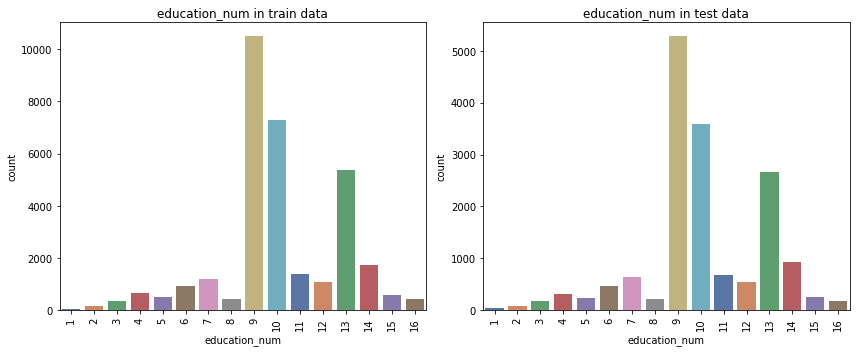

In [31]:
plot_counts("education_num", [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

#### Column `marital status`

Most people live in a marriage as a "civilian spouse". Slightly less individuals have never married.

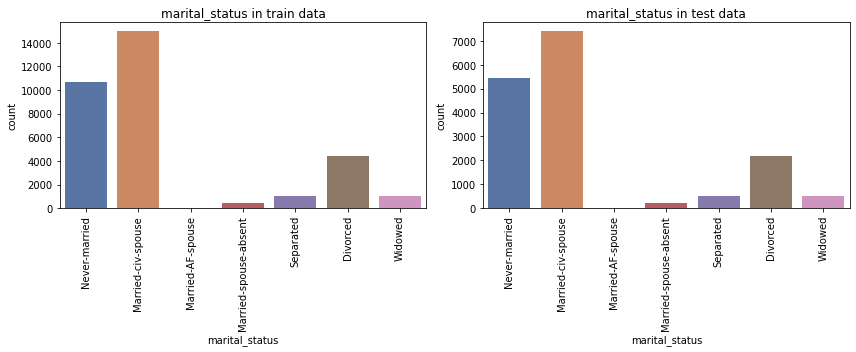

In [32]:
plot_counts("marital_status", ['Never-married', 'Married-civ-spouse', 'Married-AF-spouse', 'Married-spouse-absent', 'Separated', 'Divorced', 'Widowed'])

#### Column `relationship status`

In terms of relationship status, most individuals (in both sets) are identified as a "husband" or "not-in-family".

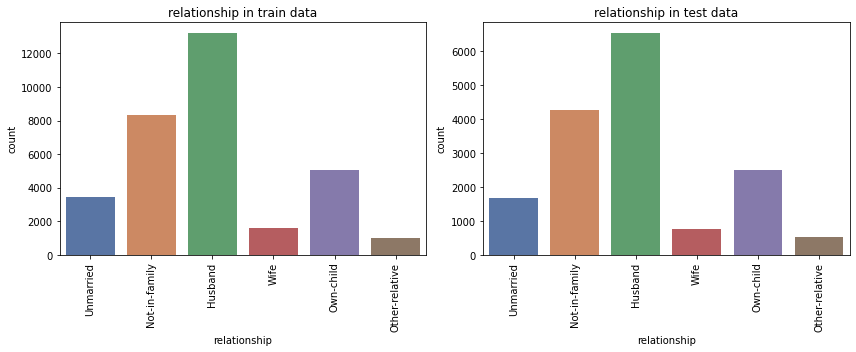

In [33]:
plot_counts("relationship", ['Unmarried', 'Not-in-family', 'Husband', 'Wife', 'Own-child', 'Other-relative'])

#### Column `race`

People were categorised in four racial groups. Most identify themselves as "whites".

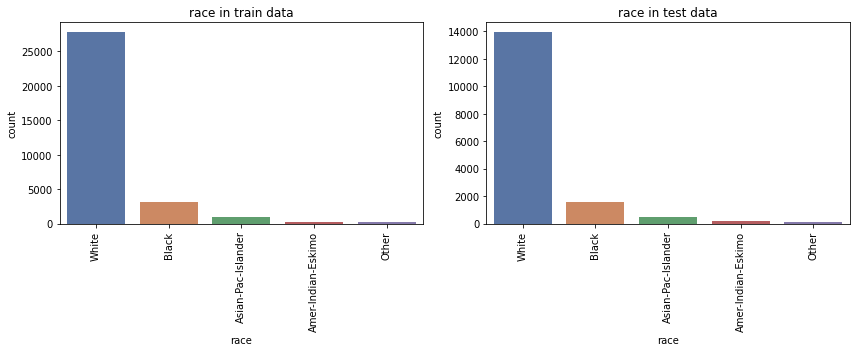

In [34]:
plot_counts("race", ['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other'])

#### Column `sex`

Males outnumber females in both train and test data. Men are twice as many as women.

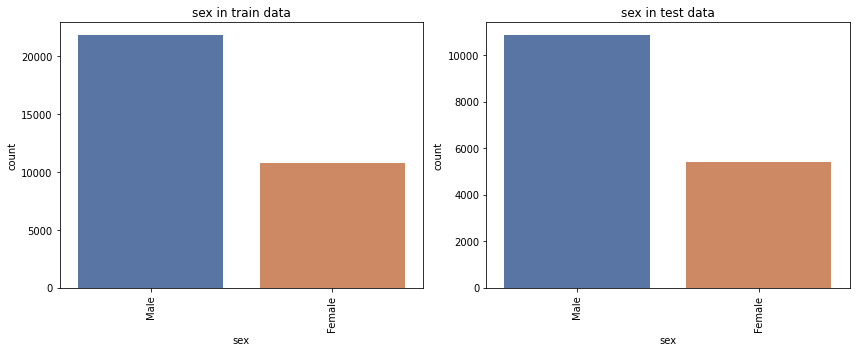

In [35]:
plot_counts("sex", ["Male", "Female"])

#### Column `occupation`

There are 15 occupational categories. These are not suitable for plotting. Instead, the number of people in occupation (in each dataset) is shown on bar plots below.

In [36]:
def plot_horizontal_bar(col):
  """
  Counts and plots categorical features on bar plot.
  Args:
    col: value counts to be displayed on the plot 
  """
  plt.figure(figsize = (12, 4))

  plt.subplot(121)
  plt.title(f"{col} in train data")
  plt.barh(adult_train.groupby(col).size().sort_values(ascending = True).index, adult_train.groupby(col).size().sort_values(ascending = True))

  plt.subplot(122)
  plt.title(f"{col} in test data")
  plt.barh(adult_test.groupby(col).size().sort_values(ascending = True).index, adult_test.groupby(col).size().sort_values(ascending = True))
 
  plt.tight_layout()
  plt.show()

Most people practice either some form of professional services or a managerial function. Many are in the administration or in sales.

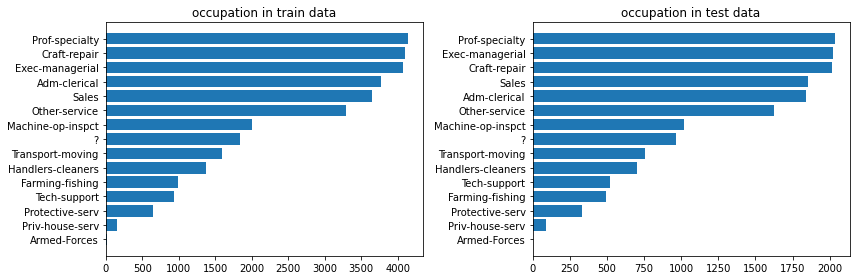

In [37]:
plot_horizontal_bar("occupation")

#### Column `native country`

People in train data were born in one out of 42 countries. Plotting all of them is not practical. For this reason, top 10 countries are selected, stored in variables (for train and test data, respectively), and visualized on bar plots.

In [38]:
len(adult_train["native_country"].unique())

42

In [39]:
adult_train_top_10_native_countries = adult_train.groupby("native_country").size().sort_values(ascending = True).tail(10)
adult_test_top_10_native_countries = adult_test.groupby("native_country").size().sort_values(ascending = True).tail(10)

Most people declared that they were born in the United States. Much less come from Mexico, or their origin is unknown. Insignificant number of individuals originate from Philippines, Germany, Canada, and so forth.

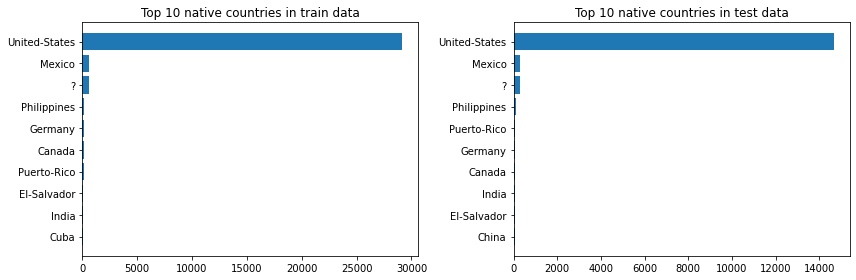

In [40]:
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.title("Top 10 native countries in train data")
plt.barh(adult_train_top_10_native_countries.index, adult_train_top_10_native_countries)

plt.subplot(122)
plt.title("Top 10 native countries in test data")
plt.barh(adult_test_top_10_native_countries.index, adult_test_top_10_native_countries)
 
plt.tight_layout()
plt.show()

#### Column `income`

A minor remark: strings in `income` column of test data end with a dot. It is removed; if kept untouched, there would have been 4 instead of 2 labels. The code line below removes the dot. Counts in each set are displayed thereafter. They show that three times more people make less than \$50000 compared to those earning above this threshold.

In [41]:
adult_test["income"] = adult_test.apply(lambda x: x["income"][:-1], axis = 1)

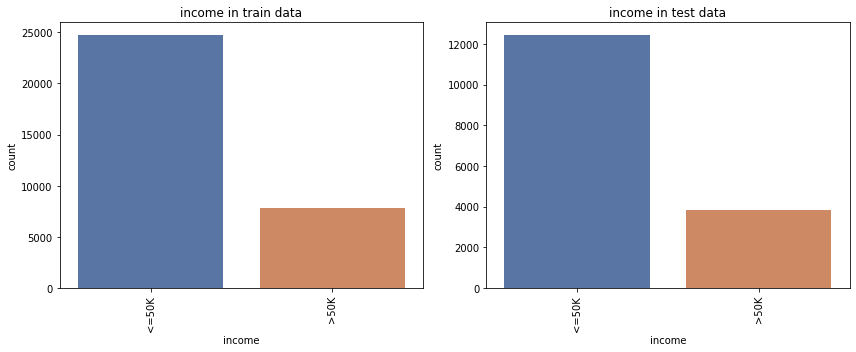

In [42]:
plot_counts("income", ['<=50K', '>50K'])

### 2.6. Cross-checks

Cross checks show relationships between variables. For example, the plots below display the number of hours per week worked by people in each occupational category (in both sets).

In [43]:
def get_mean_working_hours_by_income(dataframe):
  """
  Computes mean working hour per week per occupation
  Args:
    DataFrame
  Return:
    List of mean working hours per occupation.
  """
  groups = dataframe.groupby("occupation").mean()["hours_per_week"]
  return groups.sort_values(ascending = True)

In [44]:
hours_adult_train = get_mean_working_hours_by_income(adult_train)
hours_adult_test = get_mean_working_hours_by_income(adult_test)

People in farming industry work most. They are followed by those holding an executive or a managerial position. Individuals employed in households work least - around 30 hours per week.

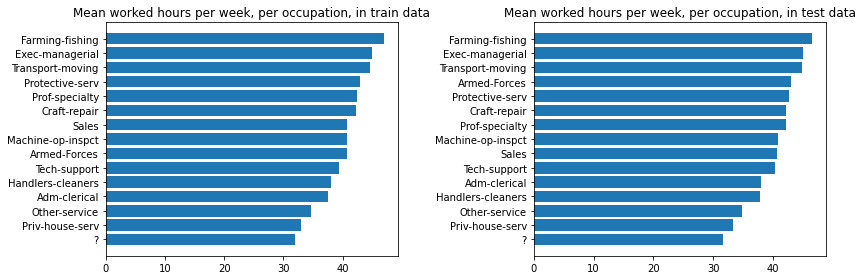

In [45]:
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.title("Mean worked hours per week, per occupation, in train data")
plt.barh(hours_adult_train.index, hours_adult_train)

plt.subplot(122)
plt.title("Mean worked hours per week, per occupation, in test data")
plt.barh(hours_adult_test.index, hours_adult_test)
 
plt.tight_layout()
plt.show()

The function below helps for displaying relationship between two categorical features.

In [46]:
def count_two_vars(var1, var2, fs1, fs2):
    """
    Counts and plots a categorical feature against another categorical feature.
    Args: 
        2 categorical features, 2 figsize values.
    Return: 
        plot showing interaction between two categorical features
    """ 
    fig, ax = plt.subplots(figsize = (fs1, fs2))
    
    plt.subplot(121)
    plt.title("In train data")
    sns.countplot(data = adult_train, x = var1, hue = var2)

    plt.subplot(122)
    plt.title("In test data")
    sns.countplot(data = adult_test, x = var1, hue = var2)

    plt.tight_layout()
    plt.show()

Values on the plot below suggest that men are more likely to earn above \$50000 than women. It should be reminded, however, that females are three times less than males in both datasets. Thus, if their number would have been balanced, it might turn out that equal share of men and women earn more than \$50000.

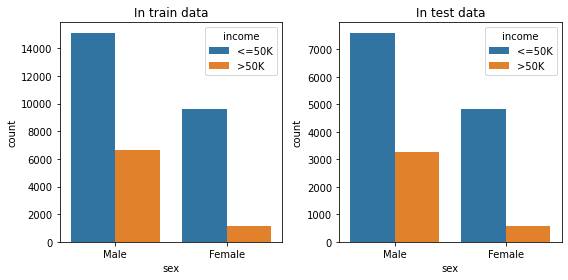

In [47]:
count_two_vars("sex", "income", 8, 4)

Similarly, it seems that white people are capable to earn more. However, this category is oversampled compared to the others.

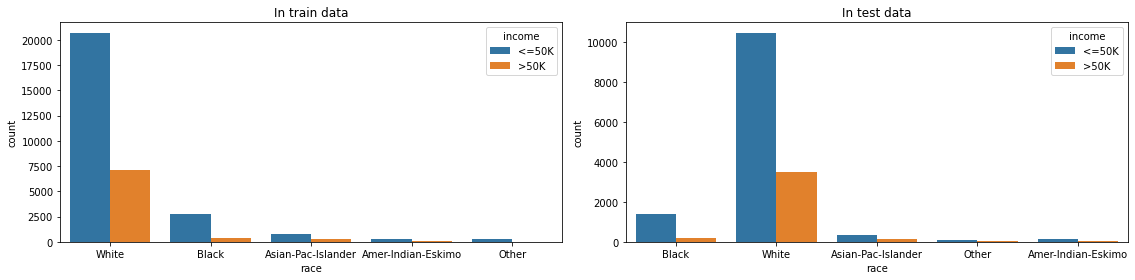

In [48]:
count_two_vars("race", "income", 16, 4)

Interestingly, married men are more likely to earn more than $50000 compared to unmarried or not-in-family people. A possible reason for this trend could be the fact that usually unmarried or not-in-family are young people who just started their career, and still do not earn a lot.

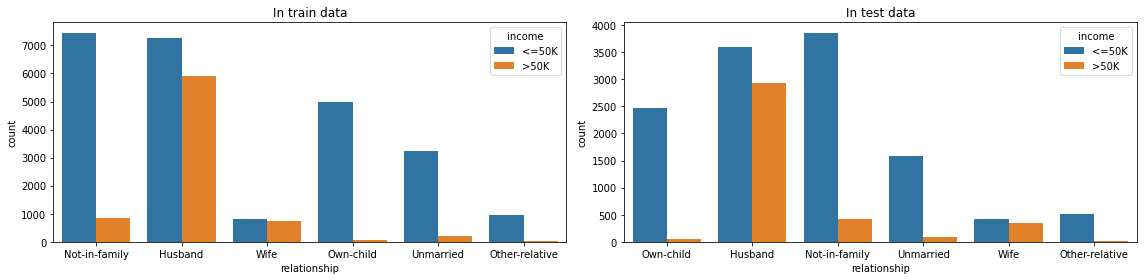

In [49]:
count_two_vars("relationship", "income", 16, 4)

## 3. Data preprocessing

During this stage, train and test data are prepared for modelling and prediction. Duplicated samples are removed. Thereafter, categorical variables are encoded with `LabelEncoder()` instead with Pandas `get_dummies()`. If the latter were to be used, number of features would have increased to more than 100, which would make interpretation much more difficult.

Next step is to separate features and labels, and to convert all values into "float" data type. The last step, before feeding the data through the modelling algorithm, is to check shape of (train and test) features and labels.

### 3.1 Remove duplicated samples

In [50]:
adult_train.drop_duplicates(inplace = True)
adult_test.drop_duplicates(inplace = True)

In [51]:
adult_train.shape, adult_test.shape

((29096, 14), (15259, 14))

### 3.2. Encode categorical variables

Nine columns hold categorical data. A single instance of `LabelEncoder()` keeps information about classes in one column (feature). Thus, there are as many encoders as the number of categorical features.

In [52]:
adult_train.head()

,age,work_class,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Train and test datasets are concatenated in a single DataFrame. Thus, each label encoder will see all possible classes, and will not skip one which might miss in one dataset and present in the other, and will not shuffle order or categories.

In [53]:
adult_train["set"] = "train"
adult_test["set"] = "test"

In [54]:
adult_all = pd.concat([adult_train, adult_test])

The next lines encode, one by one, each categorical feature.

In [55]:
encoder_work_class = LabelEncoder()
adult_all["work_class"] = encoder_work_class.fit_transform(adult_all["work_class"])

In [56]:
encoder_education = LabelEncoder()
adult_all["education"] = encoder_education.fit_transform(adult_all["education"])

In [57]:
encoder_marital_status = LabelEncoder()
adult_all["marital_status"] = encoder_marital_status.fit_transform(adult_all["marital_status"])

In [58]:
encoder_occupation = LabelEncoder()
adult_all["occupation"] = encoder_occupation.fit_transform(adult_all["occupation"])

In [59]:
encoder_relationship = LabelEncoder()
adult_all["relationship"] = encoder_relationship.fit_transform(adult_all["relationship"])

In [60]:
encoder_race = LabelEncoder()
adult_all["race"] = encoder_race.fit_transform(adult_all["race"])

In [61]:
encoder_sex = LabelEncoder()
adult_all["sex"] = encoder_sex.fit_transform(adult_all["sex"])

In [62]:
encoder_native_country = LabelEncoder()
adult_all["native_country"] = encoder_native_country.fit_transform(adult_all["native_country"])

In [63]:
encoder_income = LabelEncoder()
adult_all["income"] = encoder_income.fit_transform(adult_all["income"])

A brief check shows that all categorical features were successfully encoded.

In [64]:
adult_all.head()

,age,work_class,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,set
0,39,7,9,13,4,1,1,4,1,2174,0,40,39,0,train
1,50,6,9,13,2,4,0,4,1,0,0,13,39,0,train
2,38,4,11,9,0,6,1,4,1,0,0,40,39,0,train
3,53,4,1,7,2,6,0,2,1,0,0,40,39,0,train
4,28,4,9,13,2,10,5,2,0,0,0,40,5,0,train


Concatenated DataFrame was split into train and test datasets again.

In [65]:
train_data = adult_all[adult_all["set"] == "train"]
test_data = adult_all[adult_all["set"] == "test"]

In [66]:
train_data = train_data.drop("set", axis = 1)
test_data = test_data.drop("set", axis = 1)

### 3.3. Separate features and labels

Labels are separated from features in both sets since Machine Learning algorithms expect to get them as distinct datasets.

In [67]:
train_features = train_data.drop("income", axis = 1)
test_features = test_data.drop("income", axis = 1)

In [68]:
train_labels = train_data["income"]
test_labels = test_data["income"]

### 3.4. Change dtype

It is a good practice to convert all numerical feature values into float dtype to speed up training.

In [69]:
def make_float(features):
  """
  Convert values into float type.
  Args:
    DataFrame of features.
  Return:
    Converted DataFrame with values of float type.
  """
  return features.astype("float")

In [70]:
train_features = make_float(train_features)
test_features = make_float(test_features)

Last check of train and test features and labels. All seem to have the right shape.

In [71]:
train_features.shape, train_labels.shape, test_features.shape, test_labels.shape

((29096, 13), (29096,), (15259, 13), (15259,))

## 4. Modelling

Two modelling algorithms are tried and tested: Random Forest and XGBoost. Excessive descriptions are avoided.

`make_scorer` is used to define `f1_score` as an instance to be set as a `GridSearchCV()` parameter.

In [72]:
f1 = make_scorer(f1_score, average = "weighted")

### 4.1. Modelling with Random Forest

A range of possible values of the most common Random Forest hyper-parameters are stored in a dictionary, which is passed to `GridSearch()`.

In [73]:
params_rf = {
    "n_estimators": [10, 15, 20, 25, 30, 35],
    "max_depth": [2, 4, 6, 8, 10],
    "min_samples_leaf": [1, 2, 3, 4, 5]
}

In [74]:
rf_grid = GridSearchCV(RandomForestClassifier(random_state = 42), param_grid = params_rf, scoring = f1, cv = 5)

Train data are passed to `GridSearch()`, which is expected to find a combination of hyper-parameters that returns the best result (highest f1 score).

In [75]:
rf_grid.fit(train_features, train_labels)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'n_estimators': [10, 15, 20, 25, 30, 35]},
             scoring=make_scorer(f1_score, average=weighted))

In [76]:
rf_grid.best_params_

{'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 25}

`best_params_` applied over grid search returns the best combination of parameters. These are set in the modelling algorithm.

In [77]:
model = RandomForestClassifier(n_estimators = 25, max_depth = 10, min_samples_leaf = 4, random_state = 42)

#### 4.1.1. Model train and evaluate

To spare space and time, training, predicting and scoring tasks are wrapped in a function. It prints out "accuracy" and "f1 score" achieved by a model on a given pair of features and labels.

In [78]:
def classification_task(estimator, features, labels):
    """
    Peforms classification by training ("fit", "predict") and evaluation ("score") of a modelling alogirthm.
    Args: 
        Estimator, features (X) and labels (y).
    Return: 
        Model's performance measured in terms of accuracy and f1_score.
    """
    estimator.fit(features, labels)
    predictions = estimator.predict(features)
    
    print(f"Accuracy: {accuracy_score(labels, predictions)}")
    print(f"F1 score: {f1_score(labels, predictions, average = 'weighted')}")

"Accuracy" and "f1_score" on both train and test data do not exceed 85 - 86%.

In [79]:
classification_task(model, train_features, train_labels)

Accuracy: 0.8602900742370085
F1 score: 0.8507636123199331


In [80]:
classification_task(model, test_features, test_labels)

Accuracy: 0.8636870043908513
F1 score: 0.8540759518487707


Poor model performance could be explained with imbalanced data. f1 reaches over 90% on class 0 (representing individuals earned less than \$50000) and barely 66% on the other class. The gap is even greater when results are measured with "recall" (ratio between True Positives and the sum of True Positives and False Negatives).

In [81]:
print(classification_report(test_labels, model.predict(test_features)))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     11604
           1       0.82      0.56      0.66      3655

    accuracy                           0.86     15259
   macro avg       0.84      0.76      0.79     15259
weighted avg       0.86      0.86      0.85     15259



#### 4.1.2. Interpret results

Tree based algorithms have `feature_imortances_`. This is an array with shape (n_features,) whose values are positive and sum to 1.0. The higher the value, the more important is the contribution of the matching feature to the prediction function. 

In [82]:
importances = model.feature_importances_
importances

array([0.06837593, 0.0114897 , 0.04797653, 0.15262824, 0.14228618,
       0.02704186, 0.23170553, 0.00412922, 0.0103975 , 0.20553415,
       0.04673331, 0.04564273, 0.0060591 ])

`np.argsort` returns the sorted indices of features importance.

In [83]:
indices = np.argsort(importances)
indices

array([ 7, 12,  8,  1,  5, 11, 10,  2,  0,  4,  3,  9,  6])

Column names are stored in `features`.

In [84]:
features = train_features.columns

The plot below displays features in descending order in terms of their relative importance for the model. 

It turns out that a person's `relationship` status is the most important when it comes to earning more money. `capital_gain`, i.e., returns on made investments, also seem good predictors. On the other hand, `race`, `native_country`, `sex`, and surprisingly `work_class` are least important.

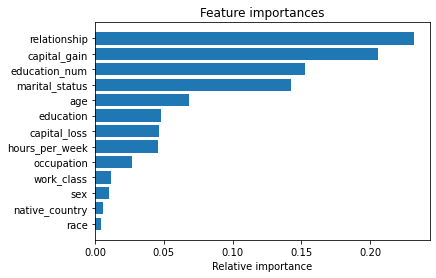

In [85]:
plt.barh(range(len(indices)), importances[indices], color = "tab:blue", align = "center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative importance")
plt.title("Feature importances")
plt.show()

Feature importance and model predictions are interpreted with SHAP as well.

[SHAP](https://shap.readthedocs.io/en/latest/) is a library, which helps for explaining Machine Learning models outputs. Its abbreviation comes from "SHapley Additive exPlanations". It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

SHAP values are used for complex models (could be a gradient boosting, a neural network, or anything that takes some features as input and produces some predictions as output) and there is a need to understand what decisions the model is making ([ref](https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30)).

What SHAP does is quantifying the contribution that each feature brings to the prediction made by the model. Shapley values are based on the idea that the outcome of each possible combination (or coalition) of features should be considered to determine the importance of a single feature.

More about SHAP and Shapley could be found in the [official documentation](https://shap.readthedocs.io) and in various publications (e.g., [here](https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30) or [here](https://towardsdatascience.com/explainable-ai-xai-with-shap-multi-class-classification-problem-64dd30f97cea)).

The code below computes SHAP values for all train features seen and modelled by Random Forest.

In [86]:
shap_values = shap.TreeExplainer(model).shap_values(train_features)

The plot below shows the impact of a feature on both classes (income categories) and how they are stacked to create the feature importance plot. This summary plot displays what the Machine Learning algorithm managed to learn from features.

It seems all columns have equal impact (are equally important) on both classes.

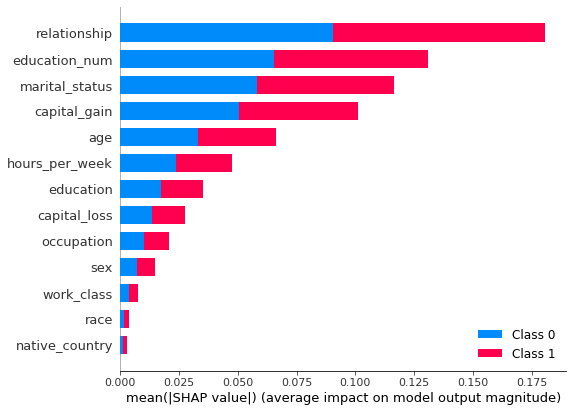

In [87]:
shap.summary_plot(shap_values, train_features)

The **summary plot** combines feature importance with feature effects. Each point is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature, and on the x-axis - by the Shapley value. 

`native_country`, being the least important feature, has low Shapley values. The color represents the value of the feature from low to high. Overlapping points are jittered in the y-axis direction, which gives a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.

The relationship between the value of a feature and the impact on prediction is visible on the summary plot.

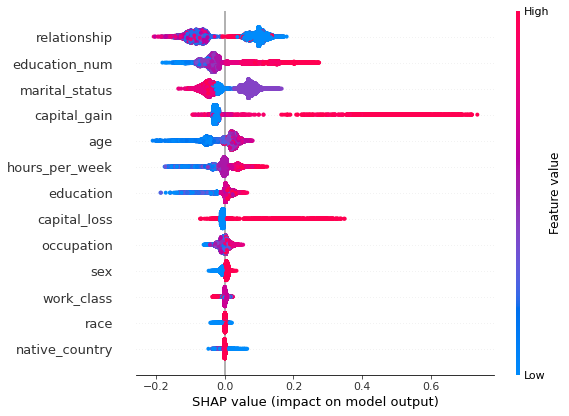

In [88]:
shap.summary_plot(shap_values[1], train_features.values, feature_names = train_features.columns)

Another very useful SHAP functionality is **force plot**. It provides explainability of a single model prediction. It shows how features contributed to the model’s prediction for a specific observation, and is very convenient for error analysis or a deep understanding of a particular case.

To illustrate how force plot works, a sample is taken out of the test data and stored in a variable. The sample holds information about a man, aged 35, self-employed working at managerial position 60 hours per week, white, husband, from the United States, completed Bachelors degree and spent 13 years in eductaion. He neither gained, nor lost capital but earned more than \$50000.

In [89]:
test_data.loc[[16280]]

,age,work_class,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
16280,35,5,9,13,2,4,0,4,1,0,0,60,39,1


In [90]:
choosen_instance = test_features.loc[[16280]]

In [91]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(choosen_instance)

In [92]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

Force plot above shows that:

> The model predicted income probability of 0.66
  
> The base value is the value that would be predicted if there was not information about any features for the current instance. The base value is the average of the model output over the training dataset (explainer.expected_value in the code). In this example base value = 0.2381

> The numbers on the plot arrows are the value of the feature for this instance. education_num = 13 and capital_gain = 0

> Red represents features that pushed the model score higher, and blue representing features that pushed the score lower.

> The bigger the arrow, the bigger the impact of the feature on the output. The amount of decrease or increase in the impact can be seen on the x-axis.

> Years in education (13) increases the property that the class is 1 (income >50K), capital gain of 0 reduces the property value.

Let's make the same exercise with another sample. It is a white man, 36 years of age, born in the United states, working in a private farming or a fishing company for 40 hours per week. He is married (husband) and has studied 9 years to complete high school. He also has neither capital gain, nor capital loss but earned less than \$50000.

In [93]:
test_data.loc[[42]]

,age,work_class,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
42,36,4,11,9,2,5,0,4,1,0,0,40,39,0


In [94]:
choosen_instance = test_features.loc[[42]]

Compute shap values for this sample.

In [95]:
shap_values = explainer.shap_values(choosen_instance)

In [96]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

From the plot it could be seen that for the second example:

> The model predicted income probability of 0.31
  
> The base value, as above, is 0.2381

> The numbers on the plot arrows are the value of the feature for this instance. In this case relationship = 0, and education_num = 9

> Red represents features that pushed the model score higher, and blue representing features that pushed the score lower.

> The bigger the arrow, the bigger the impact of the feature on the output. The amount of decrease or increase in the impact can be seen on the x-axis.

> Relationship (0) and marital status (2) increases the property that the class is 0 (income <=50K), whereas years in education (9), capital gain (0) and occupation (5) reduce the property value.

### 4.2. Modelling with XGBoost

XGBoost is used to compare Random Forest performance and model explainability. XGBoost is trained with its default settings.

In [97]:
xgb_model = xgb.XGBClassifier(random_state = 42, use_label_encoder = False)

#### 4.2.1. Model train and evaluate

In [98]:
xgb_model.fit(train_features, train_labels, eval_metric = 'logloss')

XGBClassifier(random_state=42, use_label_encoder=False)

It does not perform better in terms of "accuracy" and "f1 score", neither on train data, nor on the testing one.

In [99]:
classification_task(xgb_model, train_features, train_labels)

Accuracy: 0.8622491064063789
F1 score: 0.8550114114777122


In [100]:
classification_task(xgb_model, test_features, test_labels)

Accuracy: 0.8654564519300085
F1 score: 0.8575645330725387


Classification report scores are similar to the ones produced by Random Forest. XGBoost demonstrates high "recall" and "f1 score" on class 0 but much lower scores on the under-represented class 1.

In [101]:
print(classification_report(test_labels, xgb_model.predict(test_features)))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92     11604
           1       0.80      0.58      0.67      3655

    accuracy                           0.87     15259
   macro avg       0.84      0.77      0.79     15259
weighted avg       0.86      0.87      0.86     15259



#### 4.2.2. Interpret results

In [102]:
xgb_model.feature_importances_

array([0.05305474, 0.02225656, 0.00409082, 0.15250744, 0.10224766,
       0.04673112, 0.39158645, 0.01122328, 0.01723409, 0.10302069,
       0.04474295, 0.04721582, 0.00408832], dtype=float32)

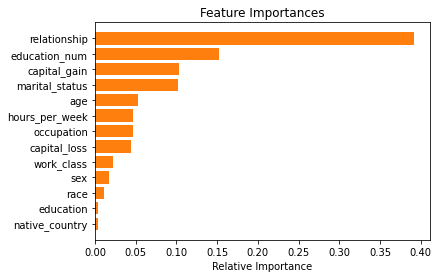

In [103]:
importances = xgb_model.feature_importances_
indices = np.argsort(importances)
features = train_features.columns
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color = "tab:orange", align = "center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

Similarly, XGBoost also considers `relationship`, `education_num`, `capital_gain`, and `marital_status` the most important features (however, `relationship` seems to have much more impact than the others). On the other hand, `sex`, `race`, `education`, and `native_country` seem to not play a significant role for determining a person's income.

SHAP values could be displayed on a bar plot. To that end, the xgb_model is passed to `shap.Explainer()`. It gets `test_features` to compute SHAP values. A brief check shows these values are stored as a 2D matrix. 

In [104]:
explainer = shap.Explainer(xgb_model, test_features)

In [105]:
shap_values = explainer(test_features)

 98%|===================| 15019/15259 [00:16<00:00]       

In [106]:
shap_values.shape

(15259, 13)

Passing this matrix of SHAP values to the bar plot function creates a global feature importance plot, where the global importance of each feature is taken to be the mean absolute value for that feature over all the given samples.

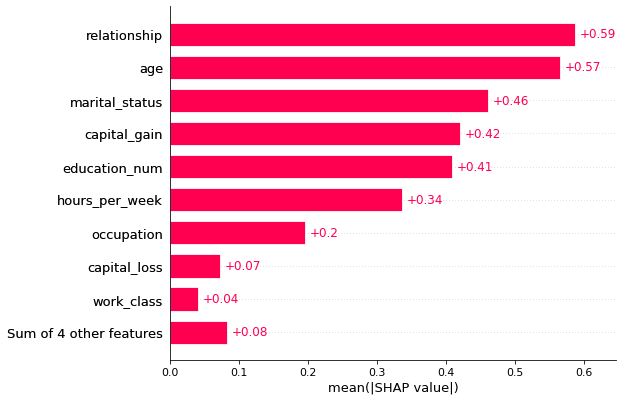

In [107]:
shap.plots.bar(shap_values)

The **waterfall plot** is another local analysis tool of a single instance prediction. 

To illustrate how it works, let’s take the fourth instance (out of test data) as an example. It holds information about a 44 years old black male, married (marital status: husband) person, who works in the private industry for 40 hours per week. He is a college graduate (10 years in education), and is an US national. It is interesting that he had capital gain of 7688 US Dollars, and his income exceeds \$50000.

In [108]:
adult_test.loc[[3]]

,age,work_class,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,set
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K,test


Waterfall plots are designed to display explanations for individual predictions, so they expect a single row of an Explanation object as input. The bottom of a waterfall plot starts as the expected value of the model output, and then each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output over the background dataset to the model output for this prediction ([ref](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html)).

Below is an example that plots the fourth explanation. Note that by default SHAP explains XGBoost classifer models in terms of their margin output, before the logistic link function. That means the units on the x-axis are log-odds units, so negative values imply probabilities of less than 0.5 that the person makes over $50k annually. The gray text before the feature names shows the value of each feature for this sample.

Probability of this sample to have income above K50 is a positive value (3.814). `capital_gain` contributes the most. It could be seen that all features save `occupation` and `race` (colored in blue) push the value higher, i.e. towards class 1. 

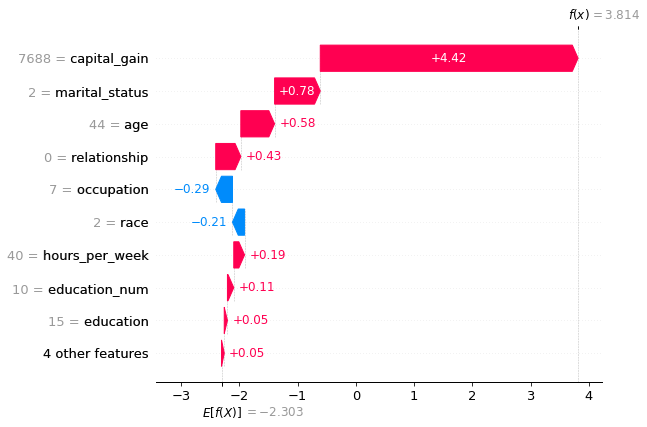

In [109]:
shap.plots.waterfall(shap_values[3])

Lastly, the waterfall plot below illustrates another example as to how features and their values impact a person's income. The sample holds data about a 72 years old divorced white woman, who spent only 4 years in education. It seems she does not have a regular work - she works only 6 hours per week. Furthermore, she had neither capital gain, nor capital loss. Logically, her earnings  are below \$50000. 

In [110]:
adult_test.loc[[22]]

,age,work_class,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,set
22,72,?,7th-8th,4,Divorced,?,Not-in-family,White,Female,0,0,6,United-States,<=50K,test


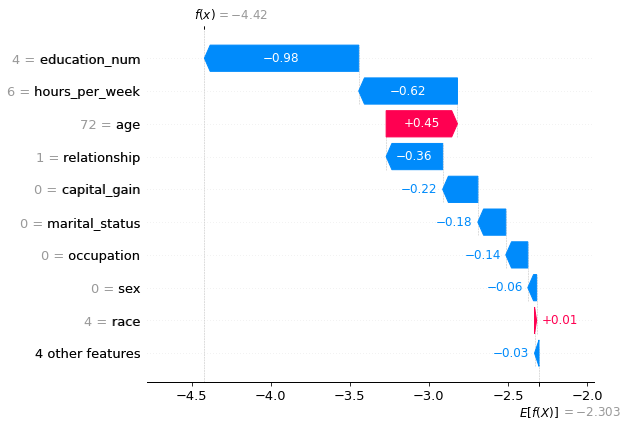

In [111]:
shap.plots.waterfall(shap_values[22])

Only `race` and `age` are in red and push values to the right. All other features hold values which, more or less, indicate a person of lower income.
- *f(x)* is the model predicted value: -4.42. It is negative, which means the probability of income above \$50000 is less than 0.5.
- *E[f(x)]* is the base value = -2.303. It is negative, which means most examples are of class 0.
- On the left are the features value and on the arrows the feature contribution to the prediction (e.g., worked 6 hours per week, which negatively contributes with -0.62 points.
- Each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output over the background dataset to the model output for this prediction.

## Conclusion

This Notebook demonstrated how SHAP framework is used and that it is an important advancement for explaining Machine Learning models. In summary, SHAP values quantify the magnitude and direction (either positive or negative) of a feature’s effect on a prediction output.